In [1]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import datapreprocessing as dp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

# Cross Validation

Do I need a developement set (to find best model) and an evaluation set with data that has not been seen before? -> YES
Do i need to do nested cross vlaidataion? -> NO
Do I need to differenciate between putting in all models and not? -> NO


## Ridge Nested Cross Validation
based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py

could potentially do stratified kfold cv https://stackoverflow.com/questions/54945196/sklearn-stratified-k-fold-cv-with-linear-model-like-elasticnetcv



In [2]:
pred, X, velocity_genes, y = dp.get_data(louvain=True)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


def r2_plot(clf):
    ax = sns.scatterplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_test_r2'], label = 'test')
    sns.scatterplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_train_r2'], label = 'train')
    ax.legend()
    ax.set_title('R2 values against for different alphas')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('R2 value')

def mse_plot(clf):
    sns.lineplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_test_neg_mean_squared_error'])
    sns.lineplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_train_neg_mean_squared_error'])



In [3]:
def parameter_plot(df, model='', parameter=''):
    fig = plt.figure()
    ax = sns.histplot(df.loc['best_param'])
    print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    round(np.std(df.loc['best_param']),4)))
    ax.set_title(model+': Parameter Distribution across all targets')
    ax.set_xlabel(parameter)
    return fig

In [4]:
def cv_plot(df, model='', parameter='', score='mean_test_r2'):
    fig = plt.figure()
    for t in df.columns.get_level_values(0).drop_duplicates():
        ax = sns.lineplot(x=df[t].params, y=df[t][score])
    
    # figure out how to print best param. / average out. 
    #print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    #np.std(df.loc['best_param'])))
    ax.set_title('Parameter Distribution: '+model+parameter)
    ax.set_xlabel(parameter)
    return fig

In [5]:
# looking at one CV case
def cv_single(df, score, best_param, name, param='param_alpha'):
    fig = plt.figure()
    splits = [col for col in df.columns if (score in col) & ('split' in col)]
    plt.plot(df[param],df[splits])
    plt.plot(df[param],df['mean_'+score], label='mean', c = 'black')
    plt.axvline(best_param, linestyle='--', color='k',
                label='CV estimate: alpha='+str(best_param))
    plt.legend()
    plt.xlabel('alpha')
    plt.ylabel(score)
    plt.title(name+' CV')
    return fig

In [6]:
def parameter_r2_plot(df, model='', parameter='', feature='best_param'):
    fig = plt.figure()
    ax = sns.scatterplot(x = df.loc[feature], y=df.loc['mean_test_r2'])
    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))
    return fig

In [35]:
def parameter_r2_violin(df, model='', parameter='', feature='best_param', path='./plots/'):
    fig = plt.figure()
    ax = sns.violinplot(x = df.loc[feature], y=df.loc['mean_test_r2'])
    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))
    return fig

In [8]:
def r2_plot(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                      x=df[('Mcm3', parameter)], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']].mean(axis=1), 
                 x=df[('Mcm3', parameter)], label='Train R2')
    ax.errorbar(df[('Mcm3', parameter)], df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                yerr=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1), fmt=' ', zorder=-1)
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    return fig

In [9]:
def r2_plot_simple(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), x=df[('Mcm3', parameter)], label='Test R2')
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    return fig

In [10]:
def mse_plot_simple(df, model='', parameter='params'):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test MSE')
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value') 
    return fig

In [65]:
def mse_plot(df, model=''):
    fig = plt.figure()
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test MSE')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Train MSE')
    ax.errorbar(df[('Mcm3', parameter)], df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1), 
                yerr=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1), fmt=' ', zorder=-1)
    ax.legend()
    ax.set_title(model+': mean MSE values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean MSE value')
    return fig

AttributeError: 'Rectangle' object has no property 'n_bins'

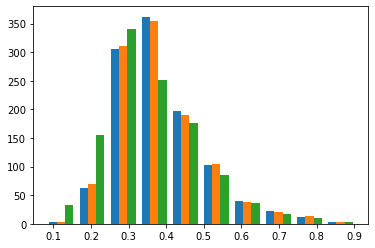

In [84]:
ax = plt.hist([best_rdf.transpose()['mean_test_r2'],best_ldf.transpose()['mean_test_r2'],best_rfdf.transpose()['mean_test_r2']], label=['ridge', 'lasso', 'rf'], n_bins=20)
ax.legend() 

In [12]:
def save_plots(filepath, to='./plots'):
    best, best_idx = compile_gridsearches_lin(filepath)
    
    

In [13]:
# load all cv
import os


def compile_gridsearches_lin(filepath):
    
    best ={}
    best_idx = {}
    
    
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        for name in filenames:
            with open(filepath+name, 'rb') as file:
                gcv = pickle.load(file)
                idx = gcv.best_index_
                
                target, apx = name.split('.')
                best_idx[target] = {'best_param': gcv.cv_results_['param_alpha'][idx],
                                'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                              'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                              'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                              }
                
                #'best_param': gcv.cv_results_['param_alpha'],
                best[target]={'params': gcv.cv_results_['param_alpha'],
                            'mean_test_r2': gcv.cv_results_['mean_test_r2'], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'],
                              'std_test_r2': gcv.cv_results_['std_test_r2'],
                              'std_train_r2':gcv.cv_results_['std_train_r2'],
                              }
    return best, best_idx

def reform(dicts):
    return {(outerKey, innerKey): values for outerKey, innerDict in dicts.items() for innerKey, values in innerDict.items()}

In [14]:
def compile_gridsearches_rf(filepath):
    
    best ={}
    best_idx = {}
    
    
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        for name in filenames:
            with open(filepath+name, 'rb') as file:
                gcv = pickle.load(file)
                idx = gcv.best_index_
                
                l = []
                for s in gcv.cv_results_['param_max_features'].data:
                    if s=='sqrt': l+=[12]
                    elif s=='auto': l+=[151]
                    elif s=='log2': l+=[7]
                    else: l+=[s]
                #gcv.cv_results_['best_param_features'] is a mask, not easily changed.. 
                
                target, apx = name.split('.')
                best_idx[target] = {'features': l[idx],
                                    'depth': gcv.cv_results_['param_max_depth'][idx],
                                'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                              'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                              'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                              }
                
                #'best_param': gcv.cv_results_['param_alpha'],
                best[target]={'features': l,
                              'depth': gcv.cv_results_['param_max_depth'],
                            'mean_test_r2': gcv.cv_results_['mean_test_r2'], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'],
                              'std_test_r2': gcv.cv_results_['std_test_r2'],
                              'std_train_r2':gcv.cv_results_['std_train_r2'],
                              }
    return best, best_idx

Okay, so random forest returns two parameters, which is why i return dict params. --> trouble for later functions.. 

# Lasso

Okay, hier functionhier die reform function nicht weil tatsächlich unterschiedlich viele parameter vorhanden sind... lasse es grade nochmal laufen, dann sehen wir weiter. 

In [15]:
lasso, best_lasso = compile_gridsearches_lin('./model_selection/Lasso(random_state=42)/')

In [16]:
ldf = pd.DataFrame(reform(lasso))
best_ldf = pd.DataFrame(best_lasso)

Average: 0.0014239362143850314 (0.0003)


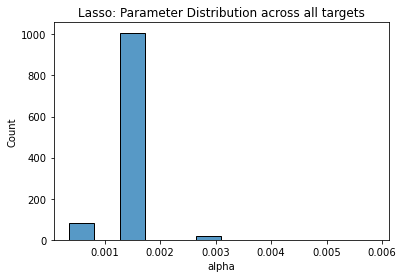

In [17]:
parameter_plot(best_ldf, parameter='alpha', model='Lasso')

Average alpha: 0.0014239362143850314 (0.0003)


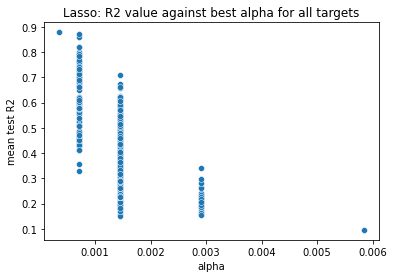

In [18]:
parameter_r2_plot(best_ldf, parameter='alpha', model='Lasso')

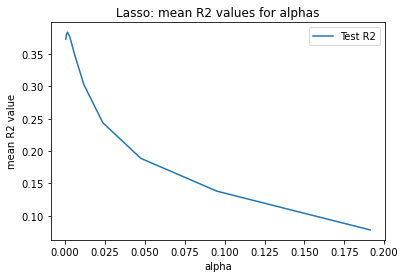

In [19]:
r2_plot_simple(ldf, model='Lasso')

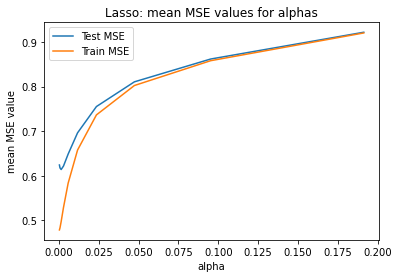

In [20]:
mse_plot(ldf, model='Lasso')

In [21]:
best_ldf.transpose().nsmallest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Tppp3,0.005839,0.095911,0.226496,-0.759395,-0.685950,0.342926,0.028757,0.130946,0.012071
H2-Ab1,0.001446,0.152427,0.284372,-0.744626,-0.641439,0.235141,0.022048,0.085339,0.009954
Ifit3,0.002906,0.156515,0.285124,-0.853512,-0.723302,0.084620,0.008008,0.021687,0.002889
Abi3,0.001446,0.158487,0.333016,-0.861006,-0.684848,0.088785,0.007664,0.035766,0.003139
Nrn1,0.002906,0.162783,0.321456,-0.782453,-0.641439,0.182521,0.015561,0.056680,0.008943


In [22]:
best_ldf.transpose().nlargest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Malat1,0.000358,0.878199,0.907319,-0.121521,-0.092723,0.007441,0.000626,0.010282,0.000845
S100a6,0.000720,0.870600,0.895663,-0.129007,-0.104441,0.003269,0.000392,0.008054,0.000796
Hsp90ab1,0.000720,0.860700,0.887509,-0.136438,-0.111239,0.009058,0.000897,0.014020,0.001295
Nap1l1,0.000720,0.818576,0.854437,-0.181472,-0.146529,0.005130,0.000508,0.014280,0.001238
Rasgrp2,0.000720,0.818498,0.853411,-0.180098,-0.146093,0.009496,0.000919,0.010485,0.000922


In [23]:
a_file = open("/home/ubuntu/volume/model_selection/Lasso(random_state=42)/Tppp3.pkl", "rb")
tpp3 = pickle.load(a_file)

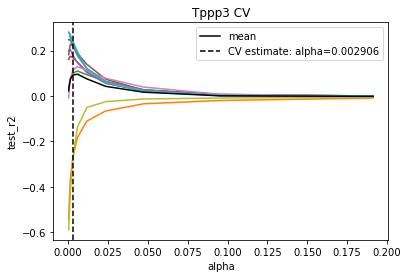

In [24]:
cv_single(pd.DataFrame(tpp3.cv_results_), name='Tppp3', best_param=0.002906, score='test_r2')

In [25]:
a_file = open("/home/ubuntu/volume/model_selection/Lasso(random_state=42)/Rasgrp2.pkl", "rb")
rasgrp2 = pickle.load(a_file)

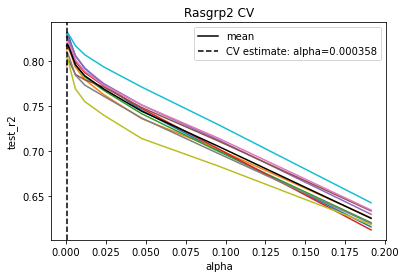

In [26]:
cv_single(pd.DataFrame(rasgrp2.cv_results_), name='Rasgrp2', best_param=0.000358, score='test_r2')

# Random Forest

Random forest lief mit max depth und n_estimators=10 2.24h

In [27]:
a_file = open("/home/ubuntu/volume/model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/Rasgrp2.pkl", "rb")
rasgrp2 = pickle.load(a_file)

In [28]:
rf, best_idx = compile_gridsearches_rf('./model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/')


In [29]:
rfdf = pd.DataFrame(reform(rf))
best_rfdf = pd.DataFrame(best_idx)

In [156]:
best_rfdf.transpose()[best_rfdf.transpose()['mean_test_neg_mean_squared_error']>-0.25]

,features,depth,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Nap1l1,151.0,30.0,0.871200,0.976442,-0.129093,-0.023716,0.010090,0.000810,0.011081,0.000764
Hif1a,151.0,50.0,0.773293,0.958317,-0.227730,-0.042116,0.011744,0.000902,0.020618,0.000833
Ctla2a,151.0,10.0,0.808239,0.935775,-0.194506,-0.065338,0.021731,0.001619,0.014415,0.001529
Depdc1b,40.0,30.0,0.813062,0.963154,-0.185548,-0.036297,0.050172,0.001924,0.032808,0.002013
Diaph3,40.0,30.0,0.776758,0.954547,-0.222555,-0.045373,0.015529,0.001072,0.010177,0.001045
Hsp90ab1,151.0,50.0,0.838892,0.970362,-0.157441,-0.029308,0.005937,0.000613,0.017225,0.000654
Malat1,40.0,50.0,0.795928,0.961170,-0.203829,-0.038849,0.013647,0.001023,0.015024,0.001010
Rasgrp2,151.0,50.0,0.904831,0.982644,-0.094285,-0.017298,0.008639,0.000438,0.010432,0.000434
Cep55,40.0,70.0,0.785488,0.960920,-0.215532,-0.039432,0.020452,0.001293,0.019058,0.001429
Tpx2,151.0,30.0,0.791644,0.961934,-0.206548,-0.037950,0.014592,0.001399,0.023361,0.001312


Average max features: 76.39675383228133 (54.5183)
Average max depth: 46.69972948602344 (19.207)


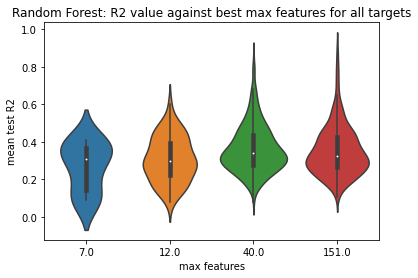

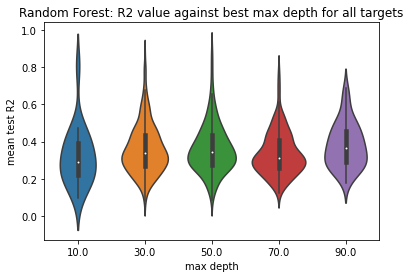

In [37]:
parameter_r2_violin(best_rfdf, parameter='max features', feature='features', model='Random Forest')
parameter_r2_violin(best_rfdf, parameter='max depth', feature='depth', model='Random Forest')

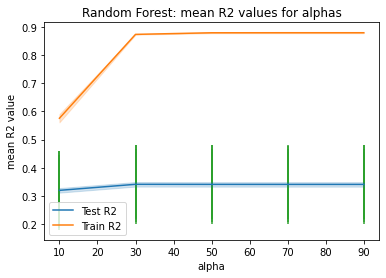

In [157]:
r2_plot(rfdf, model='Random Forest', parameter='depth')

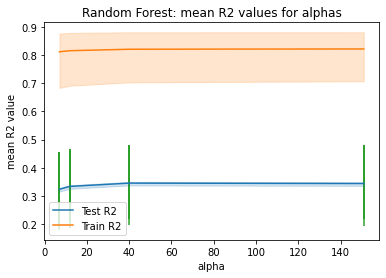

In [158]:
r2_plot(rfdf, model='Random Forest', parameter='features')

In [45]:
best_rfdf.transpose().nsmallest(5, 'mean_test_r2')

,features,depth,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Ifit3,12.0,30.0,0.078561,0.816016,-0.933454,-0.186129,0.110597,0.011736,0.043734,0.011877
Abi3,40.0,30.0,0.082394,0.821027,-0.940467,-0.183787,0.111266,0.006786,0.036311,0.005831
Nrn1,40.0,50.0,0.086271,0.824104,-0.865828,-0.166298,0.249233,0.007875,0.060326,0.006963
Tppp3,7.0,50.0,0.092532,0.832576,-0.761291,-0.148484,0.413287,0.020318,0.260369,0.022009
H2-Aa,7.0,10.0,0.096562,0.742876,-0.907774,-0.263485,0.363792,0.019792,0.075657,0.017257


In [42]:
a_file = open("/home/ubuntu/volume/model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/Tppp3.pkl", "rb")
tpp3 = pickle.load(a_file)

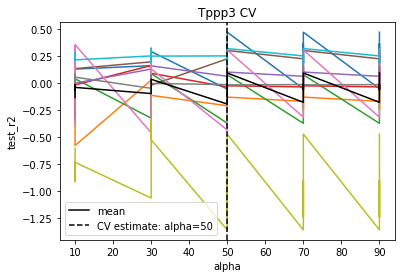

In [46]:
cv_single(pd.DataFrame(tpp3.cv_results_), score='test_r2', best_param=50, name='Tppp3', param='param_max_depth')

Das springt so komisch hier, weil es pro tiefe einpaar unterschiedliche max_features gab die ausprobiert wurden. Yuhu. 

# Ridge

In [47]:
ridge, best_ridge = compile_gridsearches_lin('./model_selection/vpred/Ridge(random_state=42)/')

In [48]:
rdf = pd.DataFrame(reform(ridge))
best_rdf = pd.DataFrame(best_ridge)

Average: 422.5879170423805 (139.6946)
Average alpha: 422.5879170423805 (139.6946)


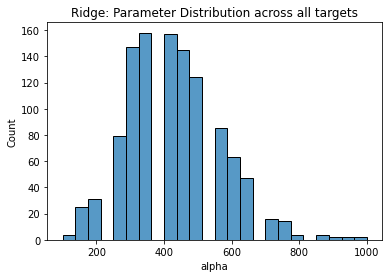

<Figure size 432x288 with 0 Axes>

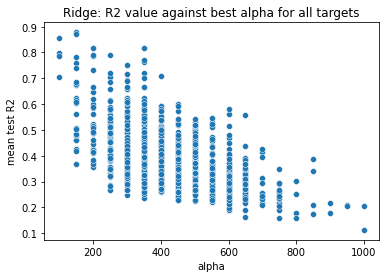

In [49]:
parameter_plot(best_rdf, parameter='alpha', model='Ridge' )
parameter_r2_plot(best_rdf, parameter='alpha', model='Ridge')
parameter_r2_violin(best_rfdf, parameter='alpha', model='Ridge')

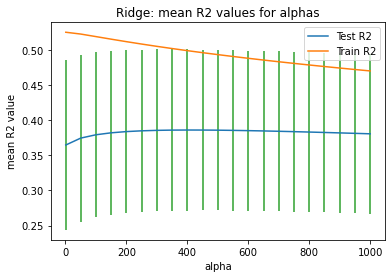

In [50]:
r2_plot(rdf, model='Ridge')

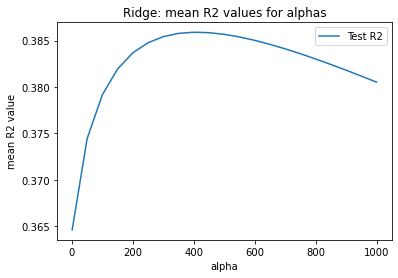

In [51]:
r2_plot_simple(rdf, model='Ridge')

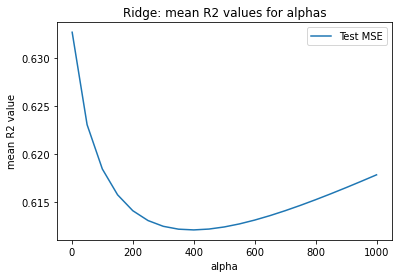

In [52]:
mse_plot_simple(rdf, model='Ridge')

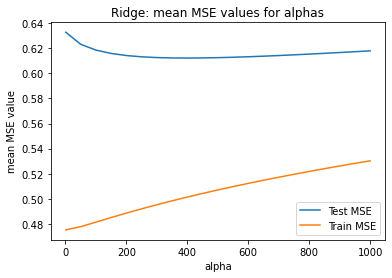

In [53]:
mse_plot(rdf, model='Ridge')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc23f5065b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc23f812d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc23f5064c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc23f8126a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc23f8128e0>,
 'means': []}

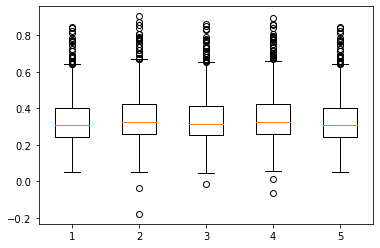

In [54]:
plt.boxplot(rfdf[[idx for idx in rfdf.columns if idx[1]=='mean_test_r2']].iloc[15:20,].transpose())

In [55]:
best_rdf.transpose().nsmallest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Tppp3,1000.0,0.112606,0.282035,-0.735798,-0.636789,0.320189,0.028272,0.154026,0.009419
H2-Ab1,750.0,0.156840,0.260696,-0.746189,-0.662720,0.246888,0.023852,0.066588,0.008325
Ifit3,800.0,0.157300,0.291969,-0.852793,-0.716377,0.085194,0.007923,0.019486,0.002482
Abi3,650.0,0.162750,0.311319,-0.857417,-0.707133,0.094127,0.008355,0.029783,0.002895
Nrn1,850.0,0.172813,0.327885,-0.774589,-0.635395,0.185417,0.016339,0.050890,0.007984


In [56]:
a_file = open("/home/ubuntu/volume/model_selection/Ridge(random_state=42)/Tppp3.pkl", "rb")
tpp3 = pickle.load(a_file)

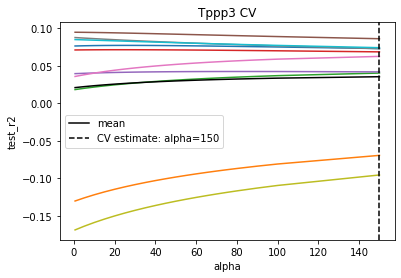

In [58]:
df = pd.DataFrame(tpp3.cv_results_)
cv_single(df, 'test_r2', name='Tppp3', best_param=150)

# Best Targets w/ threshold of 0.6

In [ ]:
# find best alpha, comparing mean mse over all hyperparameters. -> find lowest. 
# should I recalculate everyting? would the best scores change looking at mse? what I am afraid of. But this is not too bad. 

In [59]:
# return index of best alpha overall.
def best_overall_index(df):
    return df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1).argmax()

In [60]:
pred, X, velocity_genes, y = dp.get_data(louvain=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)
 

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


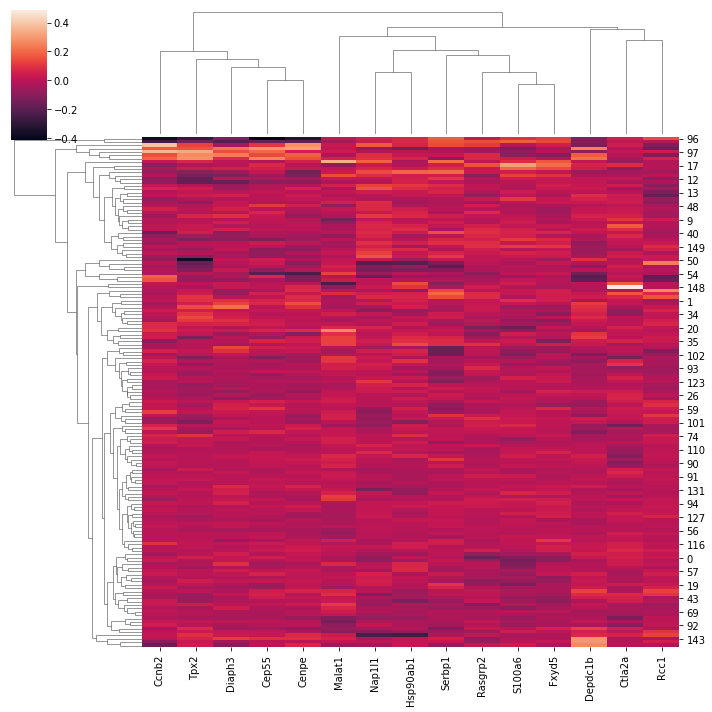

In [152]:
# overall models. 
models = rdf
path='./plots'
threshold = -0.25

def cluster_overall(models, X_train, y_train, path, clustering='complete', threshold=-0.25):
    
    index = best_overall_index(models)
    slip = models[[idx for idx in models.columns if idx[1]=='mean_test_neg_mean_squared_error']].iloc[index,:].droplevel(1)
    low = slip[slip>threshold]
    targets = low.index


    coefficients = {}  

    for idx in range(len(targets)):
        m = Ridge(alpha=rdf[('Mcm3','params')][index], random_state=42)
        fitted = m.fit(X_train.loc[:, (X_train.columns != 'louvain') & (X_train.columns != targets[idx])], 
                       y_train.loc[:, targets[idx]])

        # here I should save the coefficients. --> using all training data. can validate later on. 
        # dont think I need the estimatros. well, maybe? but can also just rerun this.
        coef = fitted.coef_.tolist()
        if targets[idx] in X_train.columns: coef.insert(X_train.columns.get_loc(targets[idx]), 0)

        coefficients[targets[idx]]=coef


    cmap = sns.clustermap(pd.DataFrame(coefficients), method=clustering)   
    cmap.savefig(path+'clustermap_'+clustering+'.png')
    return cmap
    
cluster_overall(rdf, X_train, y_train, path)

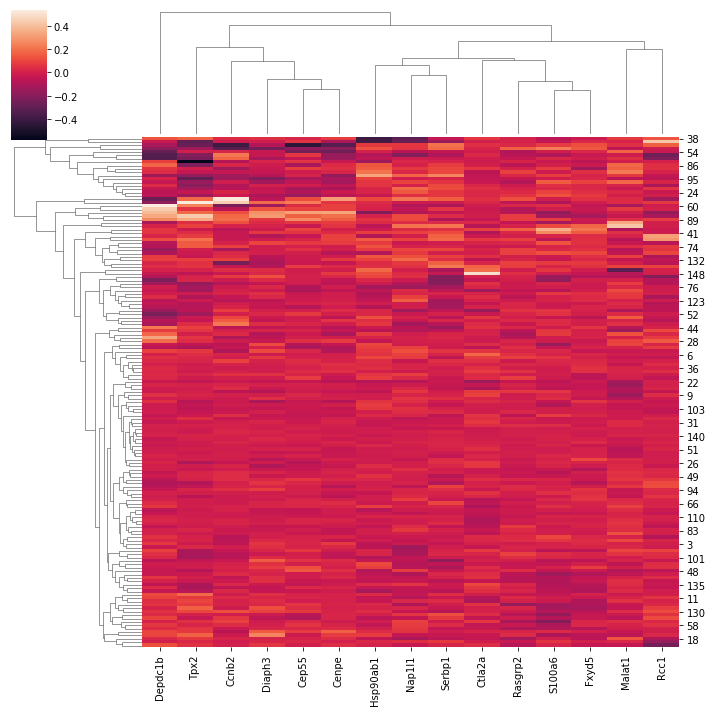

In [154]:
# train models with best hyperparameters.
models = best_rdf
path='./plots'
threshold = -0.25

def cluster_individual(models, X_train, y_train, path, clustering='complete', threshold=-0.25):
    low = models.transpose().loc[models.transpose()['mean_test_neg_mean_squared_error']>=threshold]
    targets = low.index
    hp = low['best_param']

    coefficients = {}  

    for idx in range(len(targets)):
        m = Ridge(alpha=hp[idx], random_state=42)
        fitted = m.fit(X_train.loc[:, (X_train.columns != 'louvain') & (X_train.columns != targets[idx])], 
                       y_train.loc[:, targets[idx]])

        # here I should save the coefficients. --> using all training data. can validate later on. 
        # dont think I need the estimatros. well, maybe? but can also just rerun this.
        coef = fitted.coef_.tolist()
        if targets[idx] in X_train.columns: coef.insert(X_train.columns.get_loc(targets[idx]), 0)

        coefficients[targets[idx]]=coef


    cmap = sns.clustermap(pd.DataFrame(coefficients), method=clustering)   
    cmap.savefig(path+'clustermap_'+clustering+'.png')
    return cmap

cluster_individual(models, X_train, y_train, path)

In [138]:
threshold = -0.2
bestidx = best_rdf.transpose().loc[best_rdf.transpose()['mean_test_neg_mean_squared_error']>threshold].index.tolist()
best_rdf[bestidx]

,Nap1l1,Depdc1b,Hsp90ab1,Malat1,Rasgrp2,S100a6
best_param,200.000000,100.000000,100.000000,150.000000,350.000000,150.000000
mean_test_r2,0.817673,0.796737,0.857993,0.878385,0.818906,0.870401
mean_train_r2,0.854367,0.845859,0.890003,0.906752,0.852120,0.897813
mean_test_neg_mean_squared_error,-0.182449,-0.199810,-0.139050,-0.121345,-0.179637,-0.129193
mean_train_neg_mean_squared_error,-0.146599,-0.151875,-0.108773,-0.093290,-0.147379,-0.102289
std_test_neg_mean_squared_error,0.004978,0.032292,0.009153,0.007253,0.008777,0.003347
std_train_neg_mean_squared_error,0.000509,0.002781,0.000842,0.000643,0.000829,0.000383
std_test_r2,0.013280,0.016300,0.014606,0.010014,0.010878,0.008354
std_train_r2,0.001209,0.001380,0.001278,0.000866,0.000964,0.000776


In [139]:
models=rdf
slip = models[[idx for idx in models.columns if idx[1]=='mean_test_neg_mean_squared_error']].iloc[8,:].droplevel(1)
low = slip[slip>threshold]
[x for x in bestidx if x not in low.index]

['Depdc1b']

In general there is not that much of a difference if we take the overall average best parameter, or if we take the best models. The ones that where beneath it, are consistently beneath the threshold. Not sure how to visualize this... and it may be different depending on which model is used. Ridge: 2 differences w/ 0.5, 1 w/ 0.2 and none with 0.3. More models got accepted with the individual way. But does not really matter. The ones on the boarder where on the boarder. 
Still. the coefficient values will well be different. 

Do clusters here mean anything?

Sind das dieselben gene, die gut vorhersehbar sind bei allen modellen? 

not sure what to do with random forest. 

MSE ->
top genes. 
Are there clusters of genes performing well or good

Irgendwie verwirrt mich das Lasso model. Ist es also doch nicht schlimm dass es nicht konvergiert? Warum ist der kleinste Wert der beste? 

Ridge runs through in 5 mins. THe lasso as well (with parallelization..)

In [ ]:
a_file = open("/home/ubuntu/volume/model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/Mcm3.pkl", "rb")
mcm3 = pickle.load(a_file)

In [ ]:
mcm3.best_params_


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)


In [ ]:
# Display results
fig = plt.figure()
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')

In [ ]:
model.alphas_.shape

In [ ]:
pred, X, velocity_genes, y = dp.get_data(predictors='velocity_genes', louvain=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
import time


EPSILON = 1e-4

t1 = time.time()
model = LassoCV(cv=20).fit(X_train.loc[:, X_train.columns != 'louvain'], 
                                                            y_train.loc[:, 'Aatf'])
t_lasso_cv = time.time() - t1

# Display results
fig = plt.figure()
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
#plt.ylim(ymin, ymax)


In [ ]:
#filenames = ['Pdcd1.pkl', 'Actr3.pkl', 'Stk17b.pkl', 'Mcm6.pkl', 'Tmem163.pkl', 'Ikzf2.pkl', 'Nab1.pkl', 'Ncl.pkl', 'Prim2.pkl', 'Lax1.pkl', 'Mcm3.pkl', 'Fhl2.pkl', 'Smap1.pkl', 'Rev1.pkl', 'Bcl2.pkl', 'Hjurp.pkl', 'Mrpl15.pkl', 'Wdr12.pkl', 'Zranb3.pkl', 'Ikbke.pkl', 'Bard1.pkl', 'Pask.pkl', 'Mybl1.pkl', 'Cd55.pkl', 'Pecr.pkl', 'Aff3.pkl', 'Dyrk3.pkl', '1700019D03Rik.pkl', 'Rgs1.pkl', 'Rgs2.pkl', 'Uck2.pkl', 'Atp2b4.pkl', 'Mndal.pkl', 'BC094916.pkl', 'Tor3a.pkl', 'Gm4955.pkl', 'Pydc4.pkl', 'Capn2.pkl', 'Fasl.pkl', 'Hsd11b1.pkl', 'Map4k4.pkl', 'Dtl.pkl', 'Nuf2.pkl', 'Rrp15.pkl', 'Il18r1.pkl', 'Atp1b1.pkl', 'Smyd2.pkl', 'Cenpf.pkl', 'Wdr75.pkl', 'Il18rap.pkl', 'Stat1.pkl', 'Atf3.pkl', 'Ifi204.pkl', 'Il1r2.pkl', 'Il1rl1.pkl', 'Icos.pkl', 'Sp100.pkl', 'Nop58.pkl', 'Ptma.pkl', 'Rqcd1.pkl', 'Sgol2a.pkl', 'Psmd1.pkl', 'Atic.pkl']
#filenames = ['Pdcd1.pkl', 'Actr3.pkl', 'Stk17b.pkl', 'Mcm6.pkl', 'Ikzf2.pkl', 'Nab1.pkl', 'Tmem163.pkl', 'Ncl.pkl', 'Prim2.pkl', 'Lax1.pkl', 'Fhl2.pkl', 'Smap1.pkl', 'Mcm3.pkl', 'Rev1.pkl', 'Bcl2.pkl', 'Mrpl15.pkl', 'Hjurp.pkl', 'Wdr12.pkl', 'Zranb3.pkl', 'Ikbke.pkl', 'Bard1.pkl', 'Pask.pkl', 'Mybl1.pkl', 'Cd55.pkl', 'Aff3.pkl', 'Pecr.pkl', 'Dyrk3.pkl', '1700019D03Rik.pkl', 'Rgs1.pkl', 'Rgs2.pkl', 'Uck2.pkl', 'Mndal.pkl', 'Atp2b4.pkl', 'Tor3a.pkl', 'Gm4955.pkl', 'BC094916.pkl', 'Pydc4.pkl', 'Capn2.pkl', 'Fasl.pkl', 'Hsd11b1.pkl', 'Dtl.pkl', 'Map4k4.pkl', 'Smyd2.pkl', 'Rrp15.pkl', 'Nuf2.pkl', 'Il18r1.pkl', 'Atp1b1.pkl', 'Cenpf.pkl', 'Wdr75.pkl', 'Il18rap.pkl', 'Stat1.pkl', 'Atf3.pkl', 'Ifi204.pkl', 'Il1r2.pkl', 'Il1rl1.pkl', 'Icos.pkl', 'Nop58.pkl', 'Ptma.pkl', 'Sp100.pkl', 'Rqcd1.pkl', 'Atic.pkl', 'Psmd1.pkl', 'Sgol2a.pkl', 'Nucks1.pkl', 'Nifk.pkl', 'Ube2t.pkl', 'Uchl5.pkl', 'Rgs16.pkl', 'Fam129a.pkl', 'Cd48.pkl', 'Cd244.pkl', 'Pfdn2.pkl', 'Aspm.pkl', 'Kif14.pkl', 'Chit1.pkl', 'Slamf6.pkl', 'Cenpl.pkl', 'Tagln2.pkl', 'Gm10522.pkl', 'Sell.pkl', 'Tnfsf4.pkl', 'Desi2.pkl', 'Pyhin1.pkl', 'Ipcef1.pkl', 'Parp1.pkl', 'Phactr2.pkl', 'Eprs.pkl', 'Exo1.pkl', 'Myb.pkl', 'Ddx21.pkl', 'Slc16a10.pkl', 'Foxo3.pkl', 'Fbxo5.pkl', 'Nsl1.pkl', 'Rpf2.pkl', 'Prdm1.pkl', 'Batf3.pkl', 'Gna15.pkl', 'Hsp90b1.pkl', 'Cdk1.pkl', 'Fzr1.pkl', 'Cct2.pkl', 'Rap1b.pkl', 'Parpbp.pkl', 'Tmpo.pkl', 'Adarb1.pkl', 'Utp20.pkl', 'Pwp2.pkl', 'Nup107.pkl', 'Ifngr1.pkl', 'Pa2g4.pkl', 'Dgka.pkl', 'Gas2l3.pkl', 'Zc3h12d.pkl', 'Nup43.pkl', 'Irak3.pkl', 'Sgk1.pkl', 'Fyn.pkl', 'Hdac2.pkl', 'Prep.pkl', 'Mtfr2.pkl', 'Samd3.pkl', 'Snrpd3.pkl', 'Scml4.pkl', 'Lilrb4a.pkl', 'Tube1.pkl', 'Spock2.pkl', 'Hmha1.pkl', 'Dna2.pkl', 'Palm.pkl', 'Eea1.pkl', 'Ppp1r12a.pkl', 'Ggt1.pkl', 'Atp2b1.pkl', 'Cep83.pkl', '1500009L16Rik.pkl', 'Nap1l1.pkl', 'Pwp1.pkl', 'Egr2.pkl', 'Ptges3.pkl', 'E2f7.pkl', 'Mdm1.pkl', 'Phlda1.pkl', 'Mettl1.pkl', 'Prim1.pkl', 'Timeless.pkl', 'Stat2.pkl', 'Rel.pkl', 'H2afv.pkl', 'Myo1g.pkl', 'Dock2.pkl', 'Npm1.pkl', 'Tbrg4.pkl', 'Ddx56.pkl', 'Canx.pkl', 'Anxa6.pkl', 'Il3.pkl', 'Gemin5.pkl', 'Tmem11.pkl', 'Pfas.pkl', 'Kdm6b.pkl', 'Spdl1.pkl', 'Hmmr.pkl', 'Pelp1.pkl', 'Rap1gap2.pkl', 'Tcf7.pkl', 'Shmt1.pkl', 'Aatf.pkl', 'Luc7l3.pkl', 'Slfn8.pkl', 'Utp18.pkl', 'Brip1.pkl', 'Tada2a.pkl', 'Nle1.pkl', 'Prr11.pkl', 'Top2a.pkl', 'Ikzf3.pkl', 'Cpd.pkl', 'Fam101b.pkl', 'Arl5c.pkl', 'Abi3.pkl', 'Eme1.pkl', 'Pitpnc1.pkl', 'Dhx58.pkl', 'Brca1.pkl', 'Nol11.pkl', 'Ftsj3.pkl', 'Galk1.pkl', 'Pecam1.pkl', 'Srsf2.pkl', 'Tmc6.pkl', 'Mpp2.pkl', 'Adam19.pkl', 'Cbx4.pkl', 'Tk1.pkl', 'Kif18b.pkl', 'Xpo1.pkl', 'Ccm2.pkl', 'Lcp2.pkl', 'G3bp1.pkl', 'Havcr2.pkl', 'Timp2.pkl', 'Larp1.pkl', 'Pik3ip1.pkl', 'Tnfrsf13b.pkl', 'Pik3r5.pkl', 'Slc36a1.pkl', 'Trappc1.pkl', 'Nsg2.pkl', 'Clec10a.pkl', 'Gas7.pkl', 'Suz12.pkl', 'Aurkb.pkl', 'Xaf1.pkl', 'Mettl16.pkl']
filepath = './model_selection/RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=42)/'
rf ={}

for name in filenames:
    with open(filepath+name, 'rb') as file:
        gcv = pickle.load(file)
        idx = gcv.best_index_

        target, apx = name.split('.')

        #'best_depth': gcv.cv_results_['param_max_depth'][idx],
        
        rf[target]={'best_feature': gcv.cv_results_['param_max_features'][idx], 
                      'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                      'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                      'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                      'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                      'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                      'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                      'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                      'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                      }

In [ ]:
(X_train.columns != 'louvain') & (X_train.columns != 'Mcm3')

In [ ]:
X_train.loc[:, (X_train.columns != 'louvain') & (X_train.columns != 'Mcm3')]